#YouTube Viral Video Predictor using Machine Learning

##  Data Cleaning

Minimal data cleaning was applied. A basic try-except block was used to handle any file parsing issues:

In [4]:
import pandas as pd
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
import seaborn as sns

import warnings
from collections import Counter
import datetime
import wordcloud
import json

In [5]:
try:
  df=pd.read_csv("USvideos.csv")
except pd.erros.ParserError:
  df=pd.read_csv("USvideos.csv", on_bad_lines='skip')


In [18]:
PLOT_COLORS=["#268bd2","#0052CC","#FF5722","#b58900","#003f5c"]
pd.options.display.float_format='{:.2f}'.format
sns.set(style="ticks")

plt.rc('figure',figsize=(8,5),dpi=100)
plt.rc('axes',labelpad=20,facecolor='#ffffff',linewidth=0.4,grid=True,labelsize=14)
plt.rc('patch',linewidth=0)
plt.rc('xtick.major',width=1.0)
plt.rc('ytick.major',width=0.2)
plt.rc('grid',color='#9E9E9E',linewidth=0.4)
plt.rc('grid',color='9E9E9E',linewidth=0.4)
plt.rc('font',family='sans-serif',weight='400',size=10)

plt.rc('text',color='#282828')
plt.rc('savefig',pad_inches=0.3,dpi=300)

## 🛠 Feature Engineering



In [96]:
df["title_length"] = df["title"].apply(lambda x: len(x))
df["desc_length"] = df["description"].fillna("").apply(len)
df["tag_count"] = df["tags"].apply(lambda x: 0 if x == '[none]' else len(x.split('|')))
df["publish_hour"] = pd.to_datetime(df["publish_time"]).dt.hour
df["publish_day"] = pd.to_datetime(df["publish_time"]).dt.day_name()
df["engagement_rate"] = (df["likes"] + df["dislikes"] + df["comment_count"]) / df["views"]


## 📊 Exploratory Data Analysis (EDA)


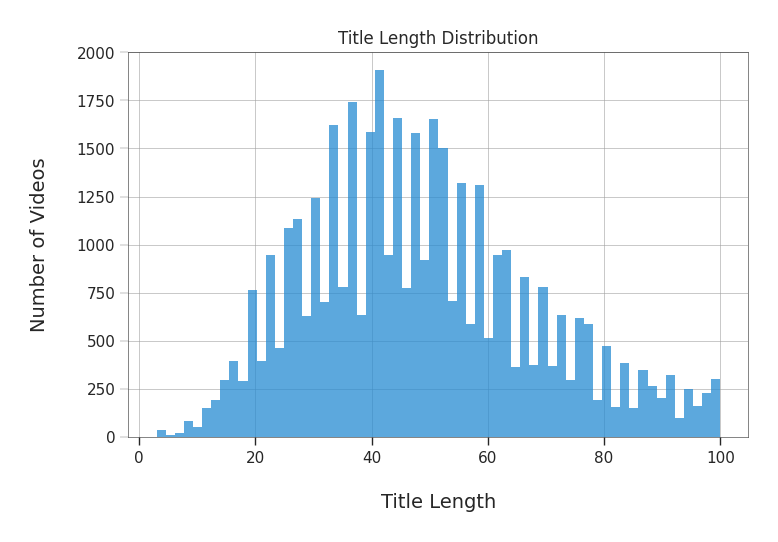

In [97]:
sns.histplot(df["title_length"], color=PLOT_COLORS[0])
plt.title("Title Length Distribution")
plt.xlabel("Title Length")
plt.ylabel("Number of Videos")
plt.show()

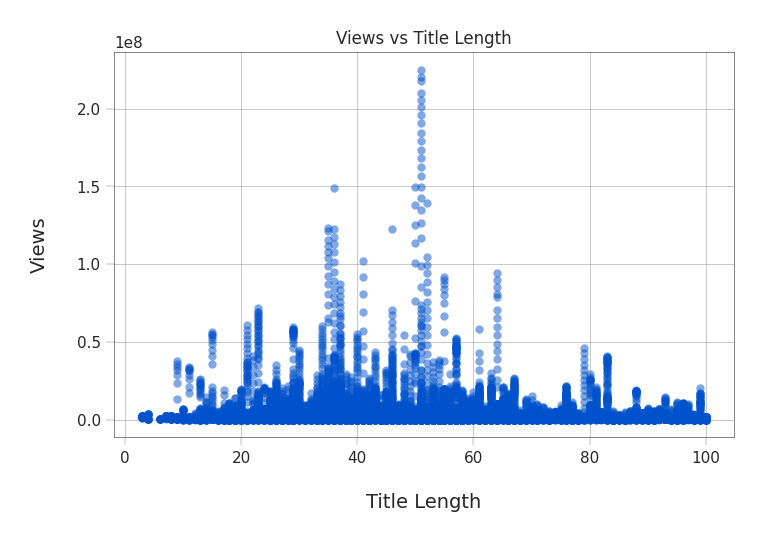

In [40]:
plt.scatter(df["title_length"], df["views"], color=PLOT_COLORS[1], alpha=0.5)
plt.xlabel("Title Length")
plt.ylabel("Views")
plt.title("Views vs Title Length")
plt.show()

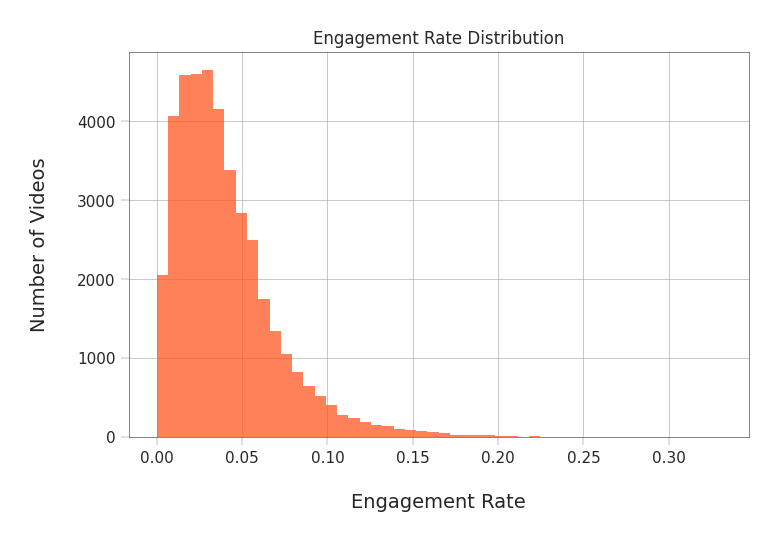

In [56]:
sns.histplot(df["engagement_rate"].dropna(), bins=50, color=PLOT_COLORS[2])
plt.title("Engagement Rate Distribution")
plt.xlabel("Engagement Rate")
plt.ylabel("Number of Videos")
plt.show()

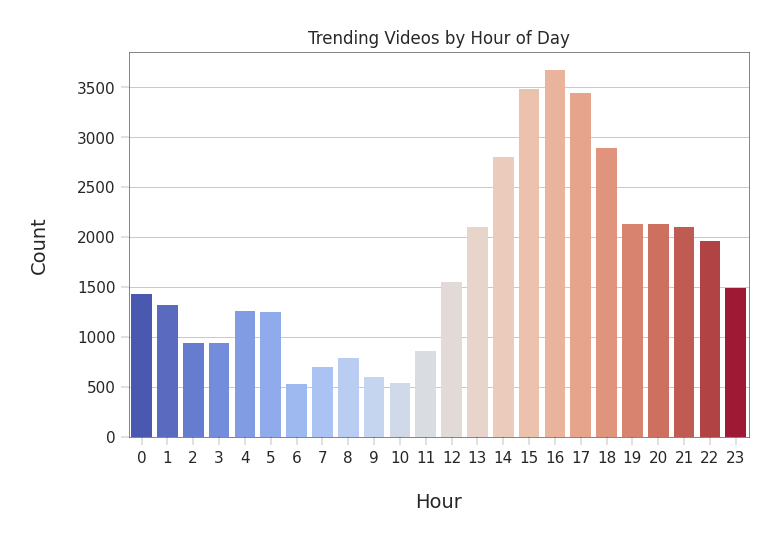

In [58]:
sns.countplot(x="publish_hour", data=df, hue="publish_hour", palette="coolwarm", legend=False)
plt.title("Trending Videos by Hour of Day")
plt.xlabel("Hour")
plt.ylabel("Count")
plt.show()

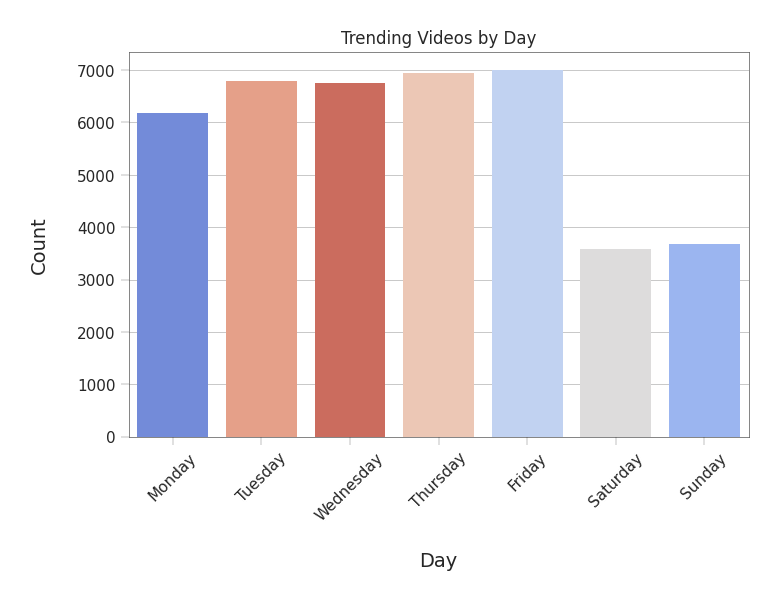

In [61]:
sns.countplot(
    x="publish_day",
    data=df,
    hue="publish_day",
    palette="coolwarm",
    order=["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"],
    legend=False
)
plt.title("Trending Videos by Day")
plt.xlabel("Day")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

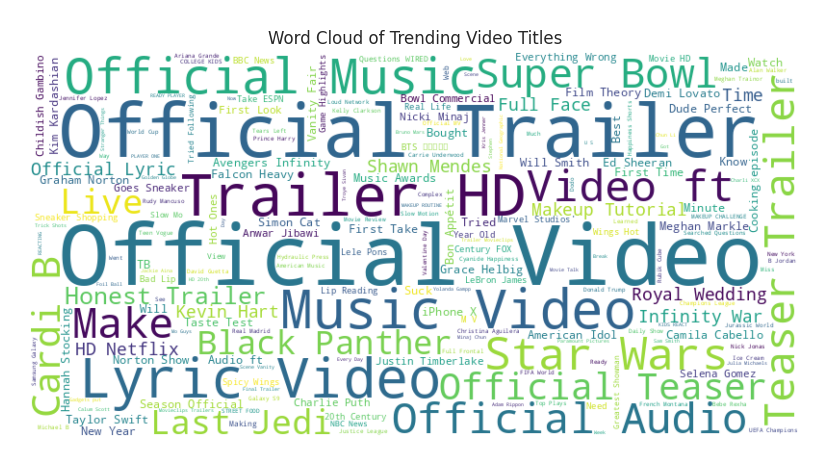

In [46]:
from wordcloud import WordCloud

text = ' '.join(df['title'].dropna())
wc = WordCloud(width=800, height=400, background_color='white').generate(text)

plt.figure(figsize=(10, 5))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud of Trending Video Titles")
plt.show()

Text(0.5, 1.0, 'Top 10 Channels by Trending Video Count')

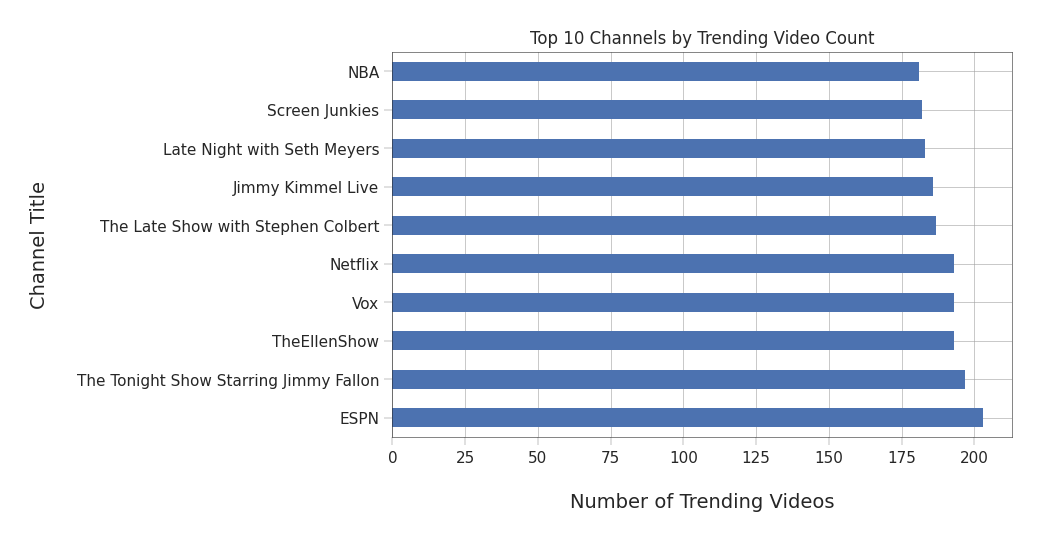

In [63]:
df["channel_title"].value_counts().head(10).plot(kind="barh")
plt.xlabel("Number of Trending Videos")
plt.ylabel("Channel Title")
plt.title("Top 10 Channels by Trending Video Count")

##🤖 Predictive Modeling

A RandomForestClassifier was trained to classify videos as viral (1) or not (0), using:
	•	Balanced class weights to address class imbalance
	•	Train/test split (70/30)
	•	Evaluation using accuracy, precision, recall, and F1-score

Viral threshold was set using:

In [69]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report,accuracy_score

In [70]:
threshold=df["views"].quantile(0.80)
df["is_viral"]=(df["views"]>=threshold).astype(int)

In [86]:
features=["title_length","desc_length","tag_count","publish_hour","publish_day","engagement_rate"]

# Select features and target
X=df[features]
Y=df["is_viral"]

# Convert 'publish_day' to numerical using one-hot encoding
X = pd.get_dummies(X, columns=['publish_day'], drop_first=True)

In [88]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

In [89]:
model=RandomForestClassifier(class_weight='balanced', random_state=42)
model.fit(X_train,Y_train)

RandomForestClassifier(class_weight='balanced', random_state=42)

In [90]:
Y_pred=model.predict(X_test)

In [91]:
print(classification_report(Y_test,Y_pred))
print("Accuracy: ",accuracy_score(Y_test,Y_pred))

              precision    recall  f1-score   support

           0       0.99      0.98      0.99      9850
           1       0.94      0.95      0.94      2435

    accuracy                           0.98     12285
   macro avg       0.96      0.97      0.96     12285
weighted avg       0.98      0.98      0.98     12285

Accuracy:  0.9767195767195768


In [92]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

classes = np.array([0, 1])
weights = compute_class_weight(class_weight='balanced', classes=classes, y=df["is_viral"])
print(dict(zip(classes, weights)))

{np.int64(0): np.float64(0.6250038157452914), np.int64(1): np.float64(2.49993894993895)}


## 🎯 Viral Video Predictor (Live Demo)

Users can now input their own video details directly into the notebook:

In [99]:
# 🧠 Get user input for a future video
print("📥 Enter your video details to predict virality:\n")

title_length = int(input("👉 Title length (number of characters): "))
desc_length = int(input("👉 Description length (number of characters): "))
tag_count = int(input("👉 Number of tags used: "))
publish_hour = int(input("👉 Hour of publishing (0–23): "))
# publish_day = int(input("👉 Day of week (0=Monday, 6=Sunday): ")) # We will get the day name
engagement_rate = float(input("👉 Estimated engagement rate (e.g. 0.05 = 5%): "))

# Get the day name from the user input number
days = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
publish_day_index = int(input(f"👉 Day of week ({', '.join([f'{i}={day}' for i, day in enumerate(days)])}): "))
publish_day = days[publish_day_index]


# 🔮 Format as a DataFrame
user_input = pd.DataFrame([{
    "title_length": title_length,
    "desc_length": desc_length,
    "tag_count": tag_count,
    "publish_hour": publish_hour,
    "publish_day": publish_day,
    "engagement_rate": engagement_rate
}])

# 🔧 Fix categorical input (publish_day) by one-hot encoding it
user_input = pd.get_dummies(user_input)

# 🔍 Align with training data’s column order
for col in model.feature_names_in_:
    if col not in user_input.columns:
        user_input[col] = 0  # fill missing dummies with 0

# Match column order exactly
user_input = user_input[model.feature_names_in_]

# 📈 Predict virality
prediction = model.predict(user_input)
prob = model.predict_proba(user_input)

print("\n🧾 Prediction:")
print("Will this video go viral? →", "Yes 🚀" if prediction[0] == 1 else "No ❌")
print("Probability of going viral:", round(prob[0][1] * 100, 2), "%")

📥 Enter your video details to predict virality:

👉 Title length (number of characters): 55
👉 Description length (number of characters): 500
👉 Number of tags used: 8
👉 Hour of publishing (0–23): 18
👉 Estimated engagement rate (e.g. 0.05 = 5%): 0.12
👉 Day of week (0=Monday, 1=Tuesday, 2=Wednesday, 3=Thursday, 4=Friday, 5=Saturday, 6=Sunday): 5

🧾 Prediction:
Will this video go viral? → No ❌
Probability of going viral: 7.0 %
